# Finding/opening ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run output using intake

This notebook demonstrates how to using intake-esm to find and load data data from the ACCESS-OM3 `MC_25km_jra_ryf-1.0-beta` test run.

For more information about using intake-esm to find and load data, see:
- the [intake-esm documentation](https://intake-esm.readthedocs.io/en/stable/)
- [this section](https://access-nri-intake-catalog.readthedocs.io/en/latest/usage/quickstart.html#using-an-intake-esm-datastore) of the access-nri-intake-catalog documentation

In [68]:
#This cell must be in all notebooks!
#It allows us to run all the notebooks at once, this cell has a tag "parameters" which allows us to pass in 
# arguments externally using papermill (see mkfigs.sh for details)

# Import my functions
functions_path = os.path.abspath("/home/566/nd0349/access-om3-analysis/functions")
if functions_path not in sys.path:
    sys.path.append(functions_path)
from get_files import *
from plot_settings import *
from fstd import *
from attenuation_models import *
test()

### USER EDIT start
# esm_file = "/g/data/ps29/nd0349/runs/access-om3/archive/mom6-cice6_ryf_rel/intake_esm_ds.json"
# esm_file = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_nomixing/experiment_datastore.json"
# esm_file = "/g/data/ol01/access-om3-output/access-om3-025/MC_25km_jra_ryf-1.0-beta-cdfb3543/experiment_datastore.json"
# esm_file = '/g/data/ol01/access-om3-output/access-om3-025/25km-iaf-test-for-AK-expt-7df5ef4c/datastore.json'
esm_file = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_defaultmixing/experiment_datastore.json"
# esm_file2 = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_nomixing/experiment_datastore.json"
esm_file2 = "/scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf/experiment_datastore.json"

# esm_file2 = "/scratch/ps29/nd0349/access-om3/archive/IC4M2-MCW-100km_jra_ryf/experiment_datastore.json"
dpi=300
### USER EDIT stop

import os
from matplotlib import rcParams
%matplotlib inline
rcParams["figure.dpi"]= dpi

plotfolder=f"/g/data/{os.environ['PROJECT']}/{os.environ['USER']}/access-om3-figs/"
os.makedirs(plotfolder, exist_ok=True)

 # a similar cell under this means it's being run in batch
print("ESM datastore path: ",esm_file)
print("Plot folder path: ",plotfolder)

Functions from get_files.py imported!
ESM datastore path:  /scratch/ps29/nd0349/access-om3/archive/IC4M8-MCW-100km_jra_ryf_defaultmixing/experiment_datastore.json
Plot folder path:  /g/data/ps29/nd0349/access-om3-figs/


In [69]:
import xarray as xr
import cf_xarray
import intake
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from distributed import Client

In [45]:
client = Client(threads_per_worker=1)
client

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44163 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:44853' processes=14 threads=14, memory=63.00 GiB>

2025-11-28 13:10:45,571 - tornado.application - ERROR - Uncaught exception GET /individual-task-stream/ws (127.0.0.1)
HTTPServerRequest(protocol='http', host='gadi-cpu-bdw-0285.gadi.nci.org.au:52862', method='GET', uri='/individual-task-stream/ws', version='HTTP/1.1', remote_ip='127.0.0.1')
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/tornado/websocket.py", line 965, in _accept_connection
    open_result = handler.open(*handler.open_args, **handler.open_kwargs)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/tornado/web.py", line 3375, in wrapper
    return method(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/bokeh/server/views/ws.py", line 149, in open
    raise ProtocolError("

In [51]:
print(client.dashboard_link)

/proxy/44163/status


### Open the intake-esm datastore

In [70]:

COLUMNS_WITH_ITERABLES = [
        "variable",
        "variable_long_name",
        "variable_standard_name",
        "variable_cell_methods",
        "variable_units"
]

datastore = intake.open_esm_datastore(
    esm_file,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


In [71]:
# esmcat = json.load(f)

In [72]:
datastore2 = intake.open_esm_datastore(
    esm_file2,
    columns_with_iterables=COLUMNS_WITH_ITERABLES
)


### What ocean variables are available at monthly frequency?

In [73]:
def available_variables(datastore):
    """Return a pandas dataframe summarising the variables in a datastore"""
    variable_columns = [col for col in datastore.df.columns if "variable" in col]
    return (
        datastore.df[variable_columns]
        .explode(variable_columns)
        .drop_duplicates()
        .set_index("variable")
        .sort_index()
    )

In [74]:
datastore_filtered = datastore.search(realm="ocean", frequency="1mon")

available_variables(datastore_filtered)

variable_long_name  \
variable                                                              
KE                               Layer kinetic energy per unit mass   
agessc                                             Ideal Age Tracer   
average_DT                                 Length of average period   
average_T1                            Start time for average period   
average_T2                              End time for average period   
hfds              Surface ocean heat flux from SW+LW+latent+sens...   
hfrainds          Heat content (relative to 0degC) of liquid+fro...   
hfrunoffds        Heat content (relative to 0C) of liquid+solid ...   
mlotst               Ocean Mixed Layer Thickness Defined by Sigma T   
mlotst_max           Ocean Mixed Layer Thickness Defined by Sigma T   
net_heat_coupler  Surface ocean heat flux from SW+LW+latent+sens...   
nv                                                    vertex number   
pbo                                 Sea Water Pressure at Sea Floor   
pso                         Sea Water Pressure at Sea Water Surface   
rhopot2                   Potential density referenced to 2000 dbar   
salt_flux_added   Salt flux into ocean at surface due to restori...   
sfdsi                              Downward Sea Ice Basal Salt Flux   
so                                                         Salinity   
speed                                             Sea Surface Speed   
tauuo                                     Surface Downward X Stress   
tauvo                                     Surface Downward Y Stress   
thetao                                        Potential Temperature   
time                                                           time   
time_bnds                                      time axis boundaries   
umo_2d                          Ocean Mass X Transport Vertical Sum   
uo                                             Sea Water X Velocity   
vmo_2d                          Ocean Mass Y Transport Vertical Sum   
vo                                             Sea Water Y Velocity   
wfo                                       Water Flux Into Sea Water   
xh                                        h point nominal longitude   
xq                                        q point nominal longitude   
yh                                         h point nominal latitude   
yq                                         q point nominal latitude   
z_i                                              Depth at interface   
z_l                                            Depth at cell center   
zos                                  Sea surface height above geoid   
zossq                      Square of sea surface height above geoid   

                                             variable_standard_name  \
variable                                                              
KE                                                                    
agessc                                             ideal_age_tracer   
average_DT                                                            
average_T1                                                            
average_T2                                                            
hfds                        surface_downward_heat_flux_in_sea_water   
hfrainds          temperature_flux_due_to_rainfall_expressed_as_...   
hfrunoffds        temperature_flux_due_to_runoff_expressed_as_he...   
mlotst               ocean_mixed_layer_thickness_defined_by_sigma_t   
mlotst_max           ocean_mixed_layer_thickness_defined_by_sigma_t   
net_heat_coupler                                                      
nv                                                                    
pbo                                 sea_water_pressure_at_sea_floor   
pso                         sea_water_pressure_at_sea_water_surface   
rhopot2                                                               
salt_flux_added                                                       
s

In [75]:
## Import data

In [76]:
ds1 = datastore.search(variable="mlotst", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                         ).to_dask().compute()
coords = coords.fillna(0.0)

coords = coords.rename({
    "geolon": "lon",
    "geolat": "lat"
})
ds1 = ds1.assign_coords(coords)
# Make CF compliant
ds1['lon'].attrs['standard_name'] = 'longitude'
ds1['lon'].attrs['units'] = 'degrees_east'
ds1['lat'].attrs['standard_name'] = 'latitude'
ds1['lat'].attrs['units'] = 'degrees_north'
ds1 = ds1.set_coords(['lon', 'lat'])

ds1


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 6MB
Dimensions:  (time: 10, yh: 300, xh: 360)
Coordinates:
  * xh       (xh) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yh       (yh) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * time     (time) object 80B 1900-01-16 12:00:00 ... 1900-10-16 12:00:00
    lon      (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 79.94 79.96 79.97 79.99
    lat      (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 66.44 66.04 65.63 65.21
Data variables:
    mlotst   (time, yh, xh) float32 4MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/18)
    NumFilesInSet:                            1
    title:                                    ACCESS-OM3
    associated_files:                         areacello: access-om3.mom6.stat...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['mlotst']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,ocean_mixed_layer_thickness...
    intake_esm_attrs:variable_cell_methods:   ,,,,area:mean yh:mean xh:mean t...
    intake_esm_attrs:variable_units:          degrees_east,degrees_north,days...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_2d_mlotst_1mon_...

In [77]:
ds1_cice = datastore.search(variable="aice_m", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"nj": -1, "ni": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore.search(variable=["TLAT", "TLON"], realm="seaIce", frequency="fx",
                          ).to_dask().compute()

coords = coords.fillna(0.0)
# ds2_cice = xr.merge(ds2_cice, coords)
ds1_cice['TLAT'] = coords['TLAT']
ds1_cice = ds1_cice.set_coords(['TLON', 'TLAT'])
ds1_cice

<xarray.Dataset> Size: 16MB
Dimensions:  (time: 10, nj: 300, ni: 360)
Coordinates:
  * time     (time) object 80B 1900-01-16 12:00:00 ... 1900-10-16 12:00:00
    TLON     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ULON     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ULAT     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    NLON     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    NLAT     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ELON     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ELAT     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    TLAT     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nj, ni
Data variables:
    aice_m   (time, nj, ni) float64 9MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

In [78]:
ds2 = datastore2.search(variable="mlotst", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore2.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                          ).to_dask().compute()
coords = coords.rename({
    "geolon": "lon",
    "geolat": "lat"
})
coords = coords.fillna(0.0)
ds2 = ds2.assign_coords(coords)

ds2['lon'].attrs['standard_name'] = 'longitude'
ds2['lon'].attrs['units'] = 'degrees_east'
ds2['lat'].attrs['standard_name'] = 'latitude'
ds2['lat'].attrs['units'] = 'degrees_north'
ds2 = ds2.set_coords(['lon', 'lat'])
ds2

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 17MB
Dimensions:  (time: 36, yh: 300, xh: 360)
Coordinates:
  * xh       (xh) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * yh       (yh) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
  * time     (time) object 288B 1900-01-16 12:00:00 ... 1902-12-16 12:00:00
    lon      (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 79.94 79.96 79.97 79.99
    lat      (yh, xh) float64 864kB 0.0 0.0 0.0 0.0 ... 66.44 66.04 65.63 65.21
Data variables:
    mlotst   (time, yh, xh) float32 16MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/16)
    NumFilesInSet:                            1
    title:                                    ACCESS-OM3
    associated_files:                         areacello: access-om3.mom6.stat...
    grid_type:                                regular
    grid_tile:                                N/A
    intake_esm_vars:                          ['mlotst']
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,ocean_mixed_layer_thickness...
    intake_esm_attrs:variable_cell_methods:   ,,,,area:mean yh:mean xh:mean t...
    intake_esm_attrs:variable_units:          degrees_east,degrees_north,days...
    intake_esm_attrs:realm:                   ocean
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_mom6_2d_mlotst_1mon_...

In [79]:
ds2_cice = datastore2.search(variable="aice_m", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"ni": -1, "nj": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

coords = datastore2.search(variable=["TLAT", "TLON"], realm="seaIce", frequency="fx",
                          ).to_dask().compute()
coords = coords.fillna(0.0)
# ds2_cice = xr.merge(ds2_cice, coords)
ds2_cice['TLAT'] = coords['TLAT']
ds2_cice = ds2_cice.set_coords(['TLON', 'TLAT'])
ds2_cice

<xarray.Dataset> Size: 38MB
Dimensions:  (time: 36, nj: 300, ni: 360)
Coordinates:
  * time     (time) object 288B 1900-01-16 12:00:00 ... 1902-12-16 12:00:00
    TLON     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ULON     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ULAT     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    NLON     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    NLAT     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ELON     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    ELAT     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
    TLAT     (nj, ni) float64 864kB nan nan nan nan nan ... nan nan nan nan nan
Dimensions without coordinates: nj, ni
Data variables:
    aice_m   (time, nj, ni) float64 31MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

In [ ]:
# ds2_cice['TLON'].plot()

### Regrid onto 100km

In [15]:
# print(ds_src.lon.shape, ds_src.lat.shape)
# print(ds_tgt.lon.shape, ds_tgt.lat.shape)

# for v in ds_src.data_vars:
#     print(v, ds_src[v].shape)

# for v in ds_tgt.data_vars:
#     print(v, ds_tgt[v].shape)

In [17]:
# 

In [ ]:
import xarray as xr
import xesmf as xe

# --- Example: assume you already have two datasets ---
ds_src = ds1.isel(time=slice(0,12))
ds_tgt = ds2

ds_src = ds_src.rename({"yh": "y", "xh": "x"})
ds_tgt = ds_tgt.rename({"yh": "y", "xh": "x"})
ds_src = ds_src.set_coords(["lon", "lat"])
ds_tgt = ds_tgt.set_coords(["lon", "lat"])

grid_src = {"lon": ds_src.lon, "lat": ds_src.lat}
grid_tgt = {"lon": ds_tgt.lon, "lat": ds_tgt.lat}

# xESMF expects grids to have lat/lon names.
# If your coordinates have different names, rename:
# ds_src = ds_src.rename({'yt_ocean': 'lat', 'xt_ocean': 'lon'})
# ds_tgt = ds_tgt.rename({'yh': 'lat', 'xh': 'lon'})

# --- Build regridder ---
regridder = xe.Regridder(
    grid_src,
    grid_tgt,
    method="bilinear",
    periodic=False,
    ignore_degenerate=True,   # required for MOM6 / tripolar grids
    reuse_weights=False,
)

# --- Apply to data variable(s) ---
# If your dataset has multiple variables, select one or apply to all.
mlotst_regridded = regridder(ds_src["mlotst"])

# --- Save or use the result ---
# ds_regridded.to_netcdf('regridded.nc')

mlotst_regridded

2025-11-28 11:52:41,924 - distributed.worker - ERROR - Failed to communicate with scheduler during heartbeat.
Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/comm/tcp.py", line 226, in read
    frames_nosplit_nbytes_bin = await stream.read_bytes(fmt_size)
                                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
tornado.iostream.StreamClosedError: Stream is closed

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/worker.py", line 1267, in heartbeat
    response = await retry_operation(
               ^^^^^^^^^^^^^^^^^^^^^^
  File "/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/distributed/utils_comm.py", line 416, in retry_operation
    return await retry(
           ^^^^^^^^^^^^
  File "/g/d

### Load and plot obs data from DeBoyer Montegut (2023)
https://doi.org/10.17882/91774

In [80]:
MLDobs = xr.open_dataset('/g/data/av17/access-nri/OM3/MLD-DeBoyerMontegut2023/mld_dr003_ref10m_v2023.nc')['mld_dr003']
MLDobs.attrs['units'] = MLDobs.attrs['unit']  # fix so plot works

# TODO: append copy of westernmost data to eastern end to avoid gap in plot

In [81]:
# small BUG: mean of monthly means is not mean of days in that month (eg Feb gets slightly more heavily weighted)
# MLDobs_JFM_mean = MLDobs.isel(time=[0, 1, 2]).mean('time').load()
# MLDobs_JAS_mean = MLDobs.isel(time=[6, 7, 8]).mean('time').load()
MLDobs

<xarray.DataArray 'mld_dr003' (time: 12, lat: 180, lon: 360)> Size: 3MB
[777600 values with dtype=float32]
Coordinates:
  * lon      (lon) float32 1kB -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time     (time) int32 48B 14 45 73 104 134 165 195 226 257 287 318 348
Attributes:
    long_name:  Mixed Layer Depth (MLD) estimated through a threshold value o...
    unit:       m
    valid_min:  10.01
    valid_max:  1221.1849
    units:      m

## Plot the comparison in MLD

In [82]:
from pathlib import Path

exp1 = Path(esm_file).parent.name
exp2 = Path(esm_file2).parent.name

print(exp1)  # mom6-cice6_ryf_rel
print(exp2)  # IC4M8-MCW-100km_jra_ryf

IC4M8-MCW-100km_jra_ryf_defaultmixing
IC4M8-MCW-100km_jra_ryf


In [83]:
ds2_cice.attrs['intake_esm_attrs:realm']

'seaIce'

### Plot against Obs

Text(0.5, 0.98, 'Comparison with observations of IC4M8-MCW-100km_jra_ryf_defaultmixing and IC4M8-MCW-100km_jra_ryf')

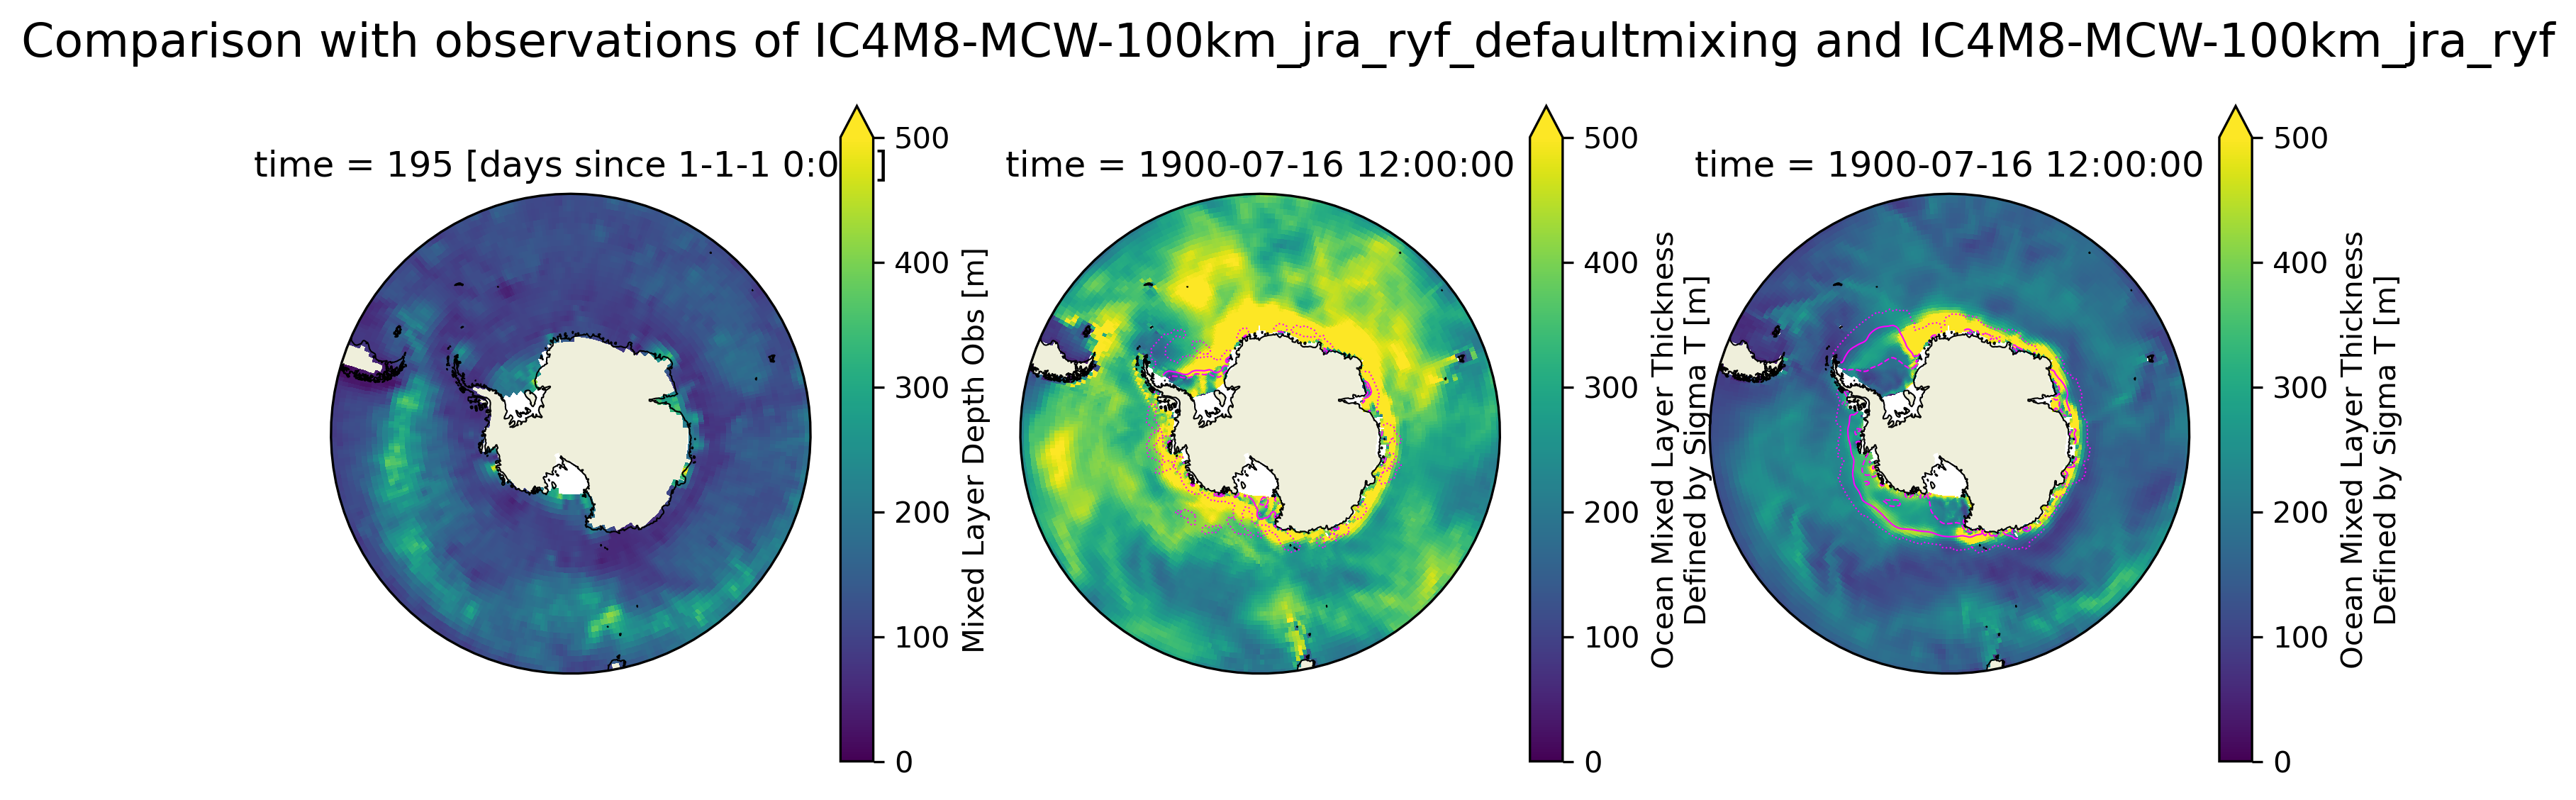

In [84]:
time_idx = 6
hemisphere = "south"
dims = [1, 3]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

# settings = get_plot_settings("mlotst")

# plot(MLDobs_JAS_mean,
#     levels=51,
#     vmin=0,
#     vmax=500,
#     extend="max",
#     cmap='viridis',
#     title=f"Observed mixed layer depth JAS mean (DeBoyer Montegut, 2023)"
#     )

MLDobs.isel(time=time_idx).plot(ax=axes[0], #x="geolon", y="geolat", 
                    vmin=0,
                    vmax=500,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
                    cbar_kwargs={'label': 'Mixed Layer Depth Obs [m]'}
) 

ds1["mlotst"].isel(time=time_idx).plot(ax=axes[1], x="lon", y="lat", 
                    vmin=0,
                    vmax=500,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 
add_ice_contours(axes[1], ds1_cice.isel(time=time_idx), hemisphere, projection)

ds2["mlotst"].isel(time=time_idx).plot(ax=axes[2], x="lon", y="lat", 
                    vmin=0,
                    vmax=500,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 
add_ice_contours(axes[2], ds2_cice.isel(time=time_idx), hemisphere, projection)


# diff = ds2["mlotst"].isel(time=time_idx) - ds1["mlotst"].isel(time=time_idx)
# diff = diff.assign_coords(coords)
# diff.plot(ax=axes[2], x="geolon", y="geolat", 
#                     vmin=-abs(diff).max().values,
#                     vmax=abs(diff).max().values,
#                     cmap=cmo.balance,
#                     transform=ccrs.PlateCarree(),
#                     cbar_kwargs={"label": "Difference [m]"} 
# ) 
fig.suptitle(f"Comparison with observations of {exp1} and {exp2}", fontsize=16)

### Plot comparison

In [79]:
ds1_cice.attrs['intake_esm_attrs:realm']

'ocean'

ValueError: zero-size array to reduction operation fmax which has no identity

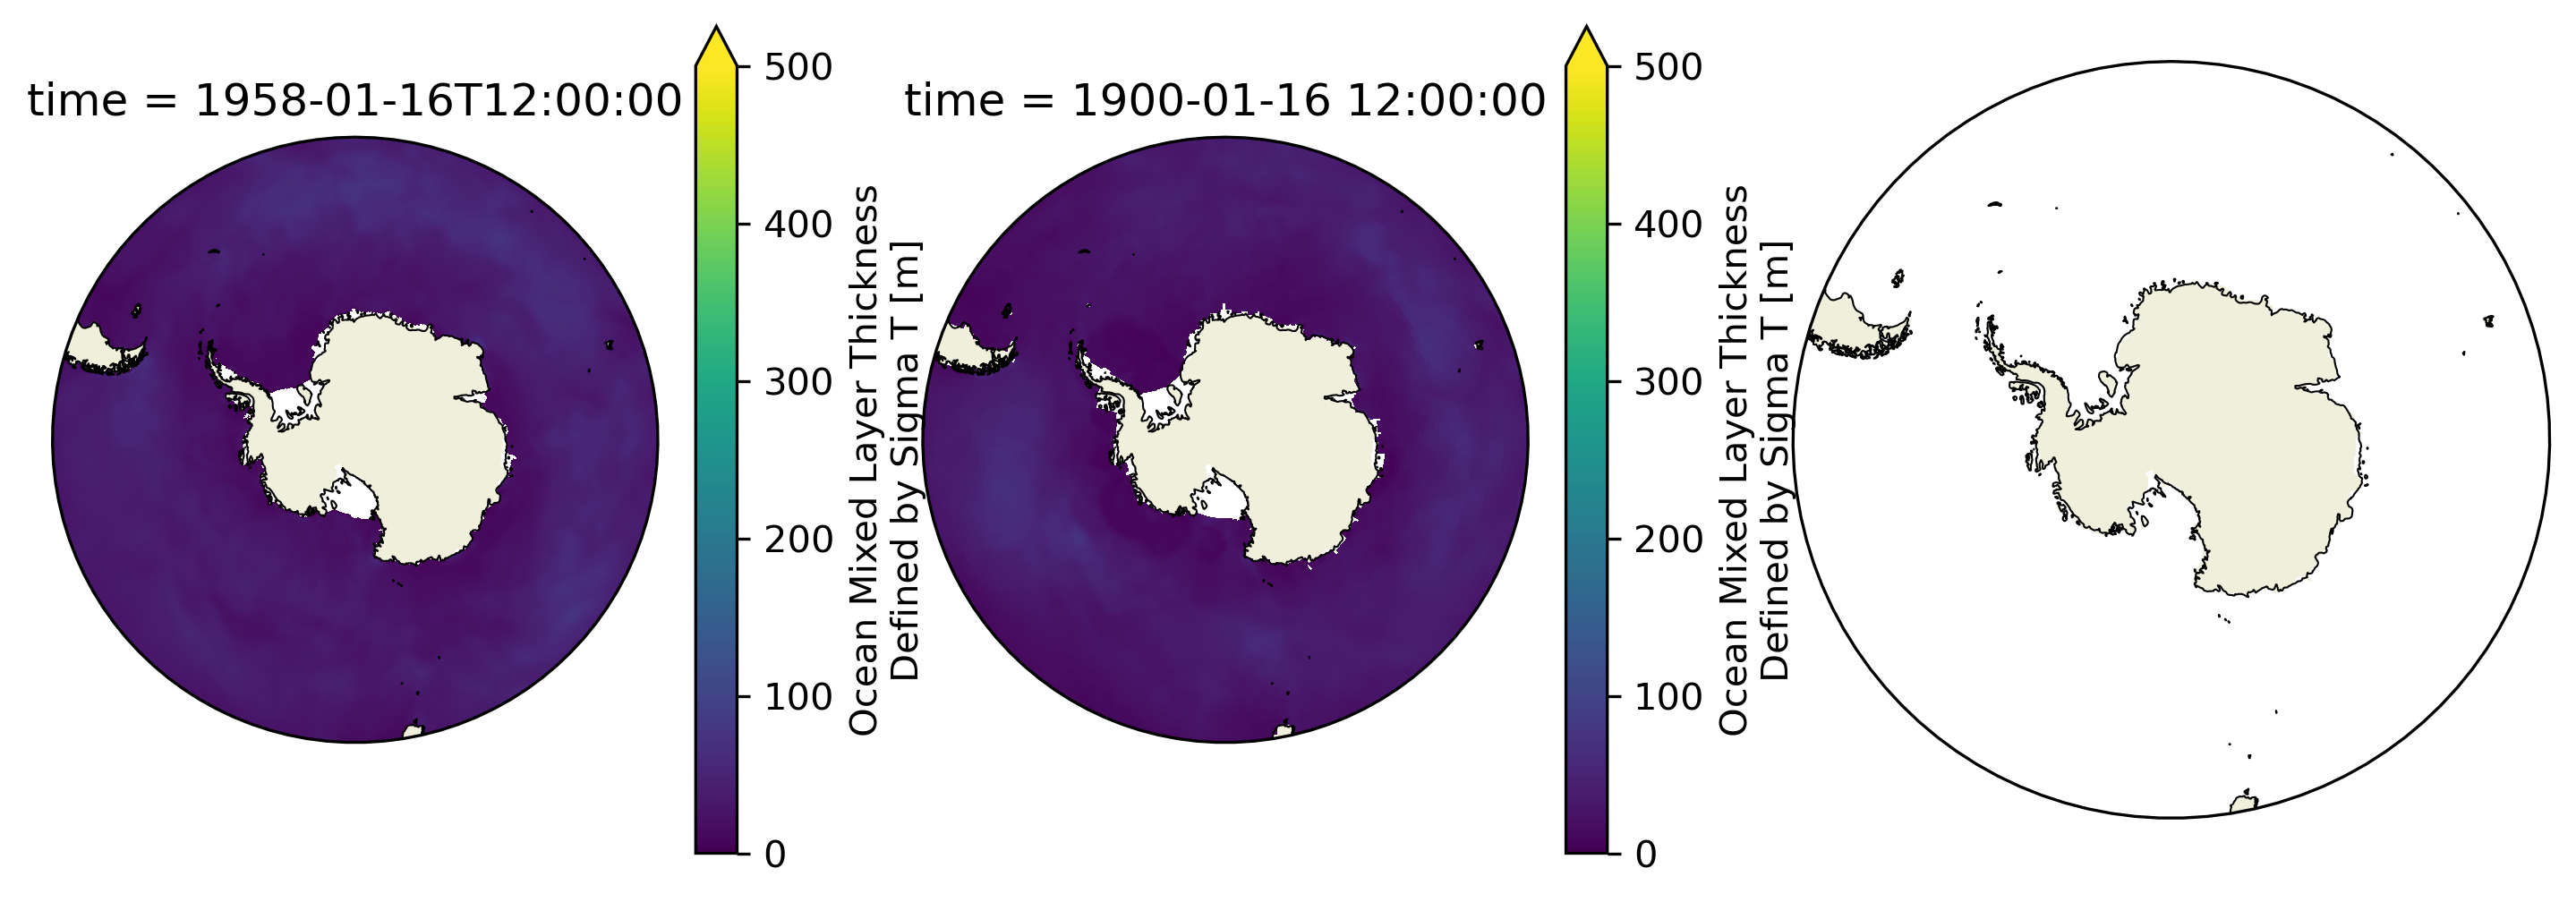

In [16]:
time_idx = 0
hemisphere = "south"
dims = [1, 3]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

settings = get_plot_settings("ICE")

ds1["mlotst"].isel(time=time_idx).plot(ax=axes[0], x="lon", y="lat", 
                    vmin=0,
                    vmax=500,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 

ds2["mlotst"].isel(time=time_idx).plot(ax=axes[1], x="lon", y="lat", 
                    vmin=0,
                    vmax=500,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 

diff = ds2["mlotst"].isel(time=time_idx) - ds1["mlotst"].isel(time=time_idx)
diff = diff.assign_coords(coords)
diff.plot(ax=axes[2], x="lon", y="lat", 
                    vmin=-abs(diff).max().values,
                    vmax=abs(diff).max().values,
                    cmap=cmo.balance,
                    transform=ccrs.PlateCarree(),
                    cbar_kwargs={"label": "Difference [m]"} 
) 
fig.suptitle(rf"Comparison of {exp1} and {exp2}", fontsize=16)

In [ ]:
datastore.search(variable="aice_m", frequency="1mon")

## Check sea ice conc

Text(0.5, 0.98, 'Comparison of 25km-iaf-test-for-AK-expt-7df5ef4c and IC4M8-MCW-100km_jra_ryf_nomixing')

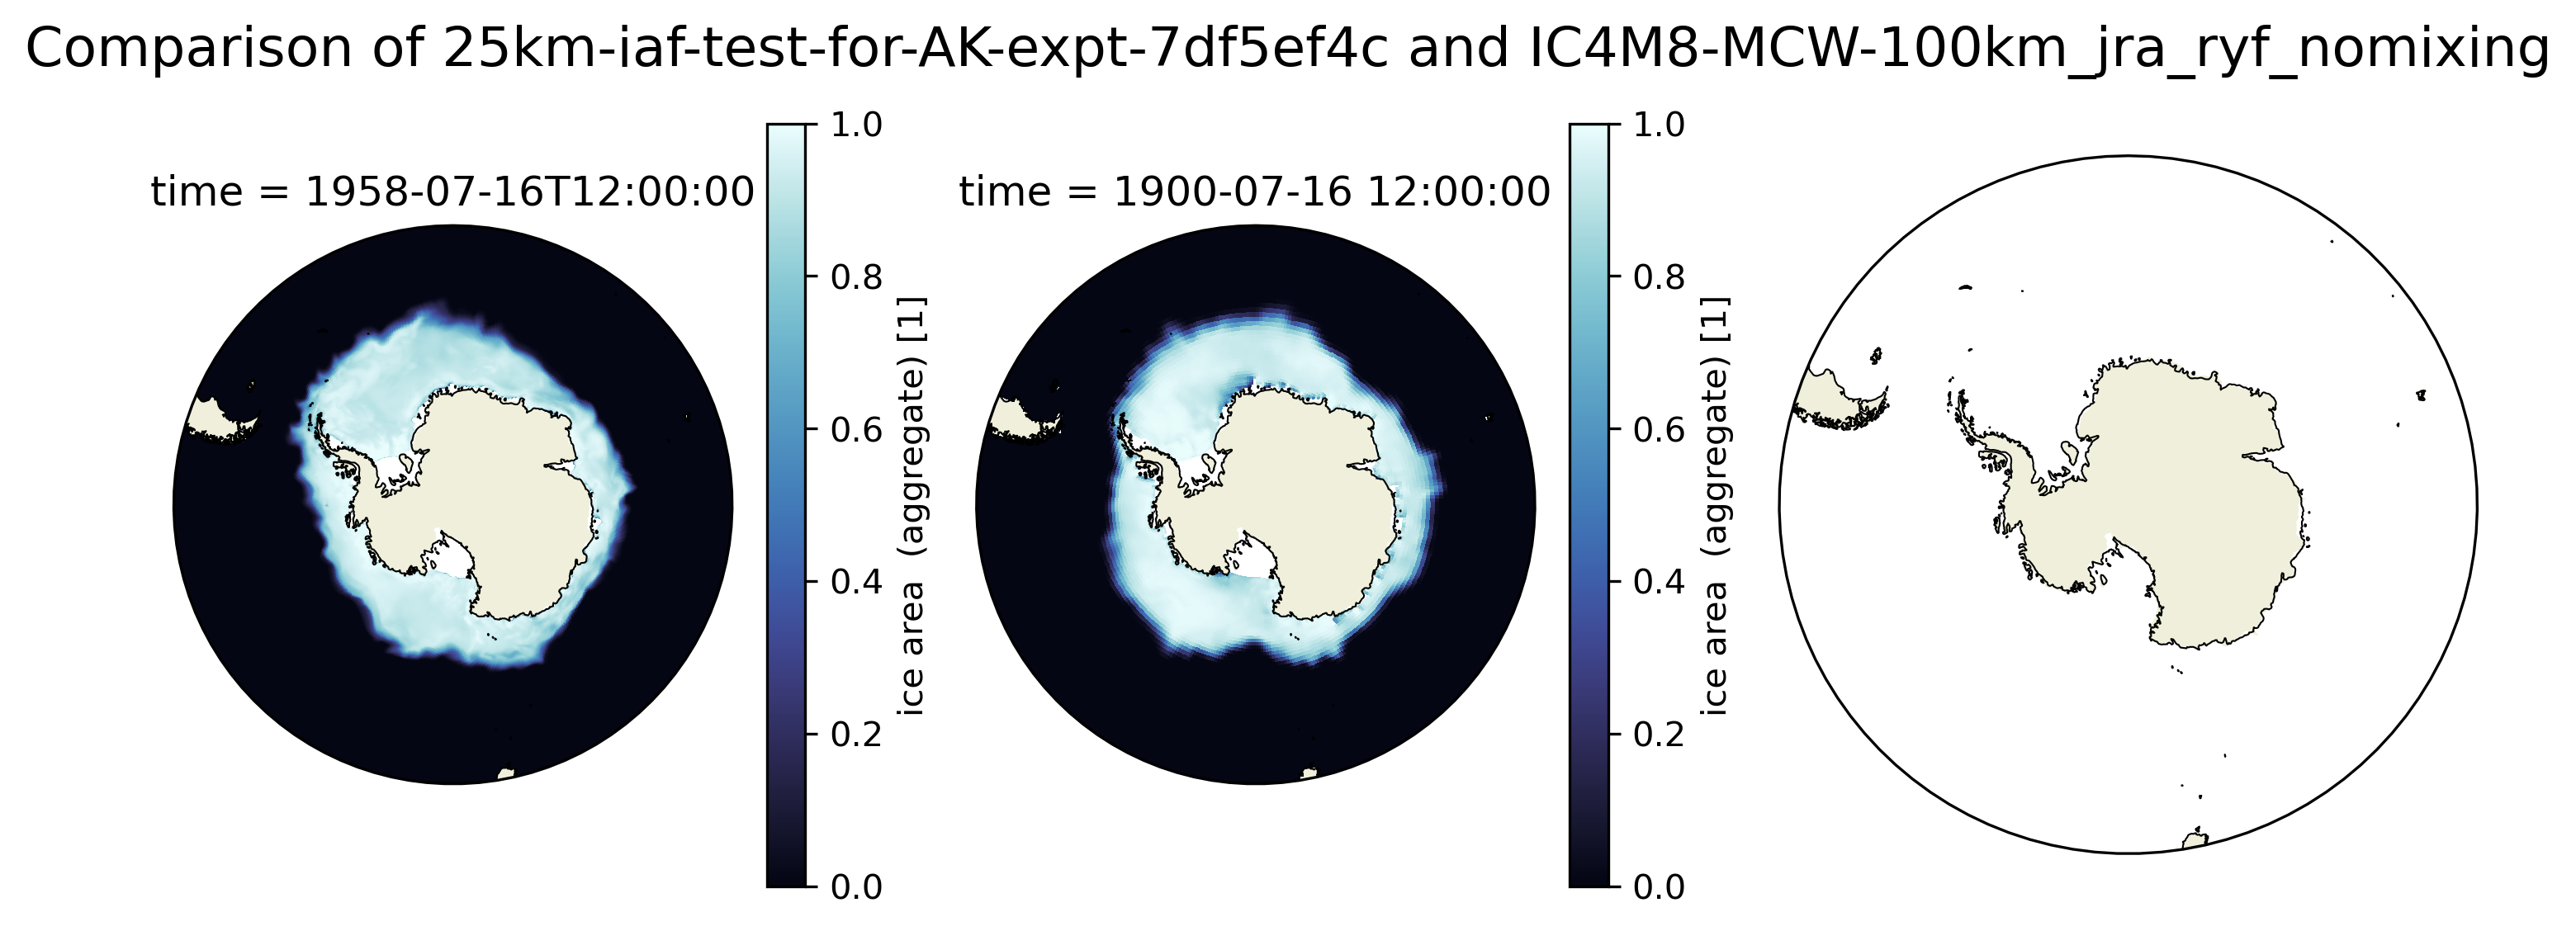

In [20]:
time_idx = 6
hemisphere = "south"
dims = [1, 3]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

settings = get_plot_settings("ICE")

ds1["aice_m"].isel(time=time_idx).plot(ax=axes[0], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=1,
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

ds2["aice_m"].isel(time=time_idx).plot(ax=axes[1], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=1,
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

# diff = ds2["aice_m"].isel(time=time_idx) - ds1["aice_m"].isel(time=time_idx)
# diff = diff.assign_coords(coords)
# diff.plot(ax=axes[2], x="geolon", y="geolat", 
#                     vmin=-abs(diff).max().values,
#                     vmax=abs(diff).max().values,
#                     cmap=cmo.balance,
#                     transform=ccrs.PlateCarree(),
#                     cbar_kwargs={"label": "Difference [m]"} 
# ) 
fig.suptitle(rf"Comparison of {exp1} and {exp2}", fontsize=16)

Text(0.5, 0.98, 'Comparison of IC4M8-MCW-100km_jra_ryf_nomixing and IC4M8-MCW-100km_jra_ryf')

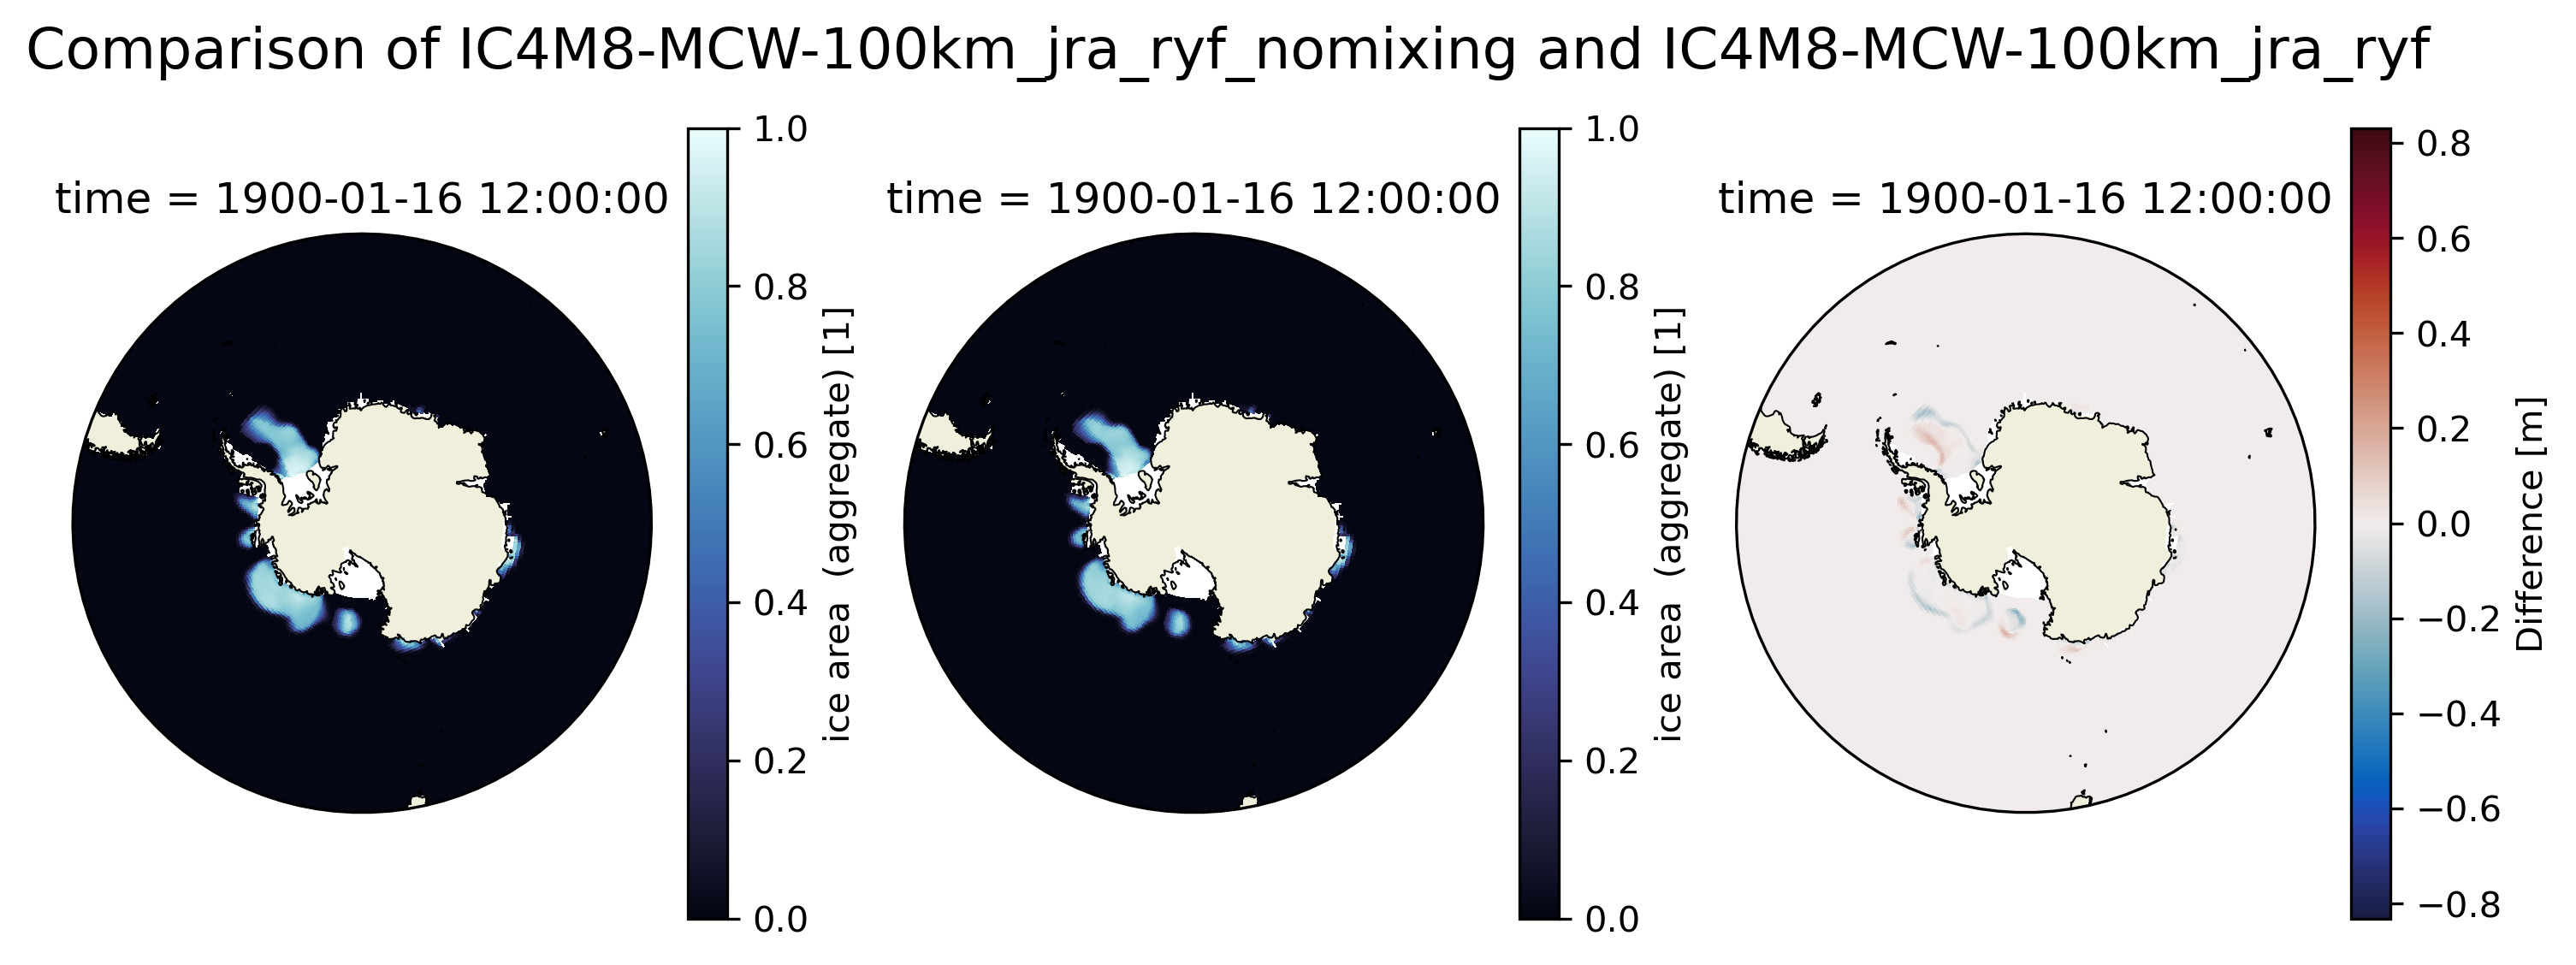

In [31]:
time_idx = 0
hemisphere = "south"
dims = [1, 3]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

settings = get_plot_settings("ICE")

ds1["aice_m"].isel(time=time_idx).plot(ax=axes[0], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=1,
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

ds2["aice_m"].isel(time=time_idx).plot(ax=axes[1], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=1,
                    cmap=cmo.ice,
                    transform=ccrs.PlateCarree(),
) 

diff = ds2["aice_m"].isel(time=time_idx) - ds1["aice_m"].isel(time=time_idx)
diff = diff.assign_coords(coords)
diff.plot(ax=axes[2], x="geolon", y="geolat", 
                    vmin=-abs(diff).max().values,
                    vmax=abs(diff).max().values,
                    cmap=cmo.balance,
                    transform=ccrs.PlateCarree(),
                    cbar_kwargs={"label": "Difference [m]"} 
) 
fig.suptitle(rf"Comparison of {exp1} and {exp2}", fontsize=16)

In [32]:
## And Hi

In [21]:
ds1 = datastore.search(variable="hi_m", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"nj": -1, "ni": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                         ).to_dask().compute()
coords = coords.fillna(0.0)
coords = coords.rename({'xh': 'ni', 'yh': 'nj'})
ds1 = ds1.assign_coords(coords)
ds1

<xarray.Dataset> Size: 3MB
Dimensions:  (time: 1, nj: 300, ni: 360)
Coordinates:
  * time     (time) object 8B 1900-01-16 12:00:00
  * ni       (ni) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * nj       (nj) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
    geolon   (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 79.94 79.96 79.97 79.99
    geolat   (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 66.44 66.04 65.63 65.21
Data variables:
    hi_m     (time, nj, ni) float64 864kB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/29)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment2:                                 File written on model date 1900...
    comment3:                                 seconds elapsed into model date...
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

In [22]:
ds2 = datastore2.search(variable="hi_m", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"ni": -1, "nj": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)
coords = datastore2.search(variable=["geolat", "geolon"], file_id='access_om3_mom6_static'
                          ).to_dask().compute()
coords = coords.fillna(0.0)
coords = coords.rename({'xh': 'ni', 'yh': 'nj'})
ds2 = ds2.assign_coords(coords)
ds2

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


<xarray.Dataset> Size: 33MB
Dimensions:  (time: 36, nj: 300, ni: 360)
Coordinates:
  * time     (time) object 288B 1900-01-16 12:00:00 ... 1902-12-16 12:00:00
  * ni       (ni) float64 3kB -279.5 -278.5 -277.5 -276.5 ... 77.5 78.5 79.5
  * nj       (nj) float64 2kB -77.88 -77.63 -77.38 -77.13 ... 88.87 89.32 89.77
    geolon   (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 79.94 79.96 79.97 79.99
    geolat   (nj, ni) float64 864kB 0.0 0.0 0.0 0.0 ... 66.44 66.04 65.63 65.21
Data variables:
    hi_m     (time, nj, ni) float64 31MB dask.array<chunksize=(1, 300, 360), meta=np.ndarray>
Attributes: (12/21)
    title:                                    access-om3
    contents:                                 Diagnostic and Prognostic Varia...
    source:                                   CICE Sea Ice Model, unknown_ver...
    comment:                                  All years have exactly 365 days
    comment3:                                 seconds elapsed into model date...
    time_period_freq:                         month_1
    ...                                       ...
    intake_esm_attrs:variable_standard_name:  ,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,...
    intake_esm_attrs:variable_cell_methods:   ,,,,,,,,,time: mean,time: mean,...
    intake_esm_attrs:variable_units:          days since 1900-01-01 00:00:00,...
    intake_esm_attrs:realm:                   seaIce
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   access_om3_cice_1mon_mean_XXXX_...

Text(0.5, 0.98, 'Comparison of IC4M8-MCW-100km_jra_ryf_nomixing and IC4M8-MCW-100km_jra_ryf')

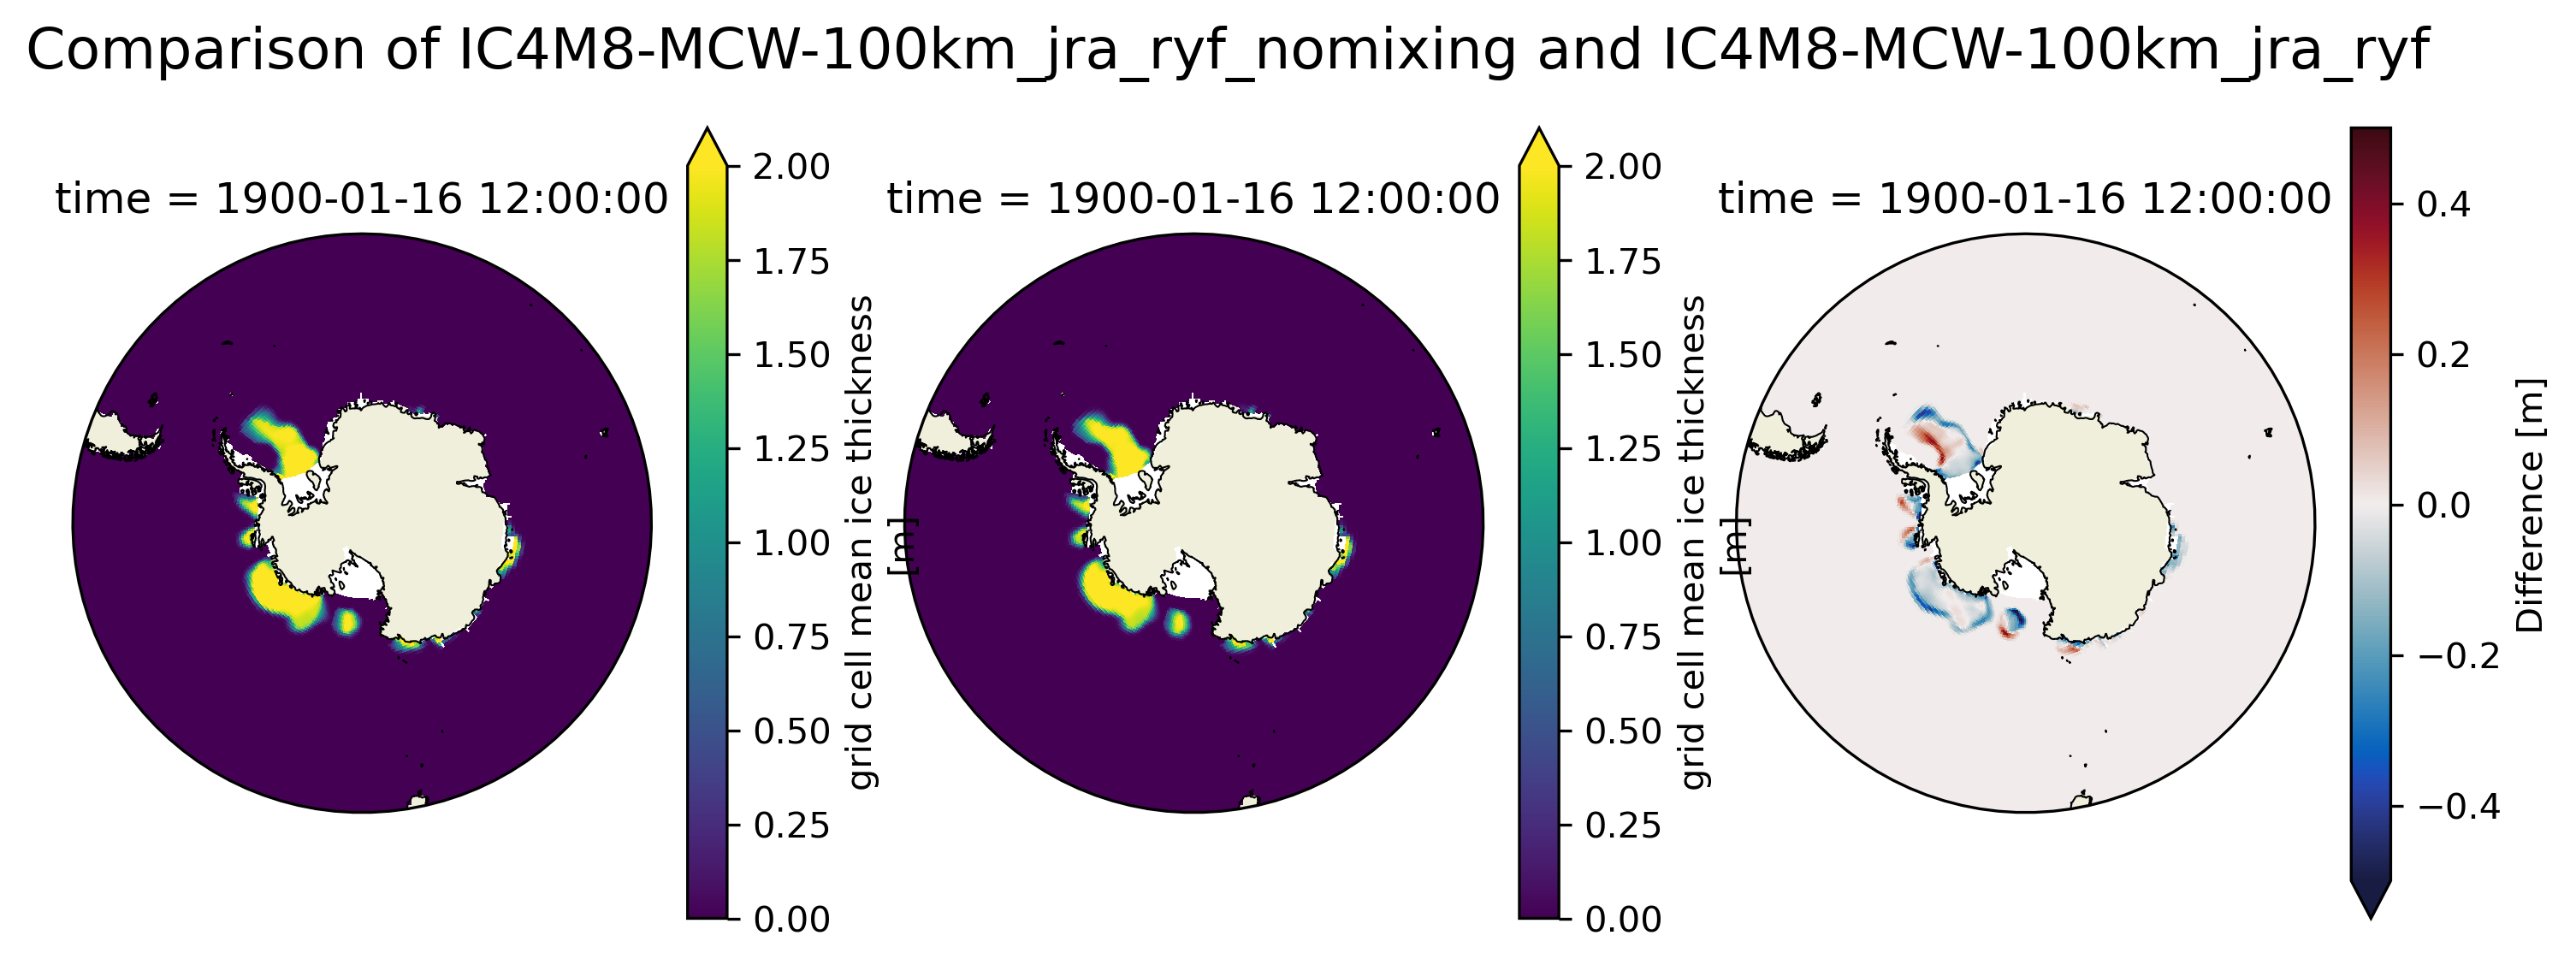

In [23]:
time_idx = 0
hemisphere = "south"
dims = [1, 3]
fig, axes, projection = basic_axis(dims, hemisphere=hemisphere)

settings = get_plot_settings("ICE")

ds1["hi_m"].isel(time=time_idx).plot(ax=axes[0], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=2,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 

ds2["hi_m"].isel(time=time_idx).plot(ax=axes[1], x="geolon", y="geolat", 
                    vmin=0,
                    vmax=2,
                    cmap='viridis',
                    transform=ccrs.PlateCarree(),
) 

diff = ds2["hi_m"].isel(time=time_idx) - ds1["hi_m"].isel(time=time_idx)
diff = diff.assign_coords(coords)
diff.plot(ax=axes[2], x="geolon", y="geolat", 
                    vmin=-0.5, #abs(diff).max().values,
                    vmax=0.5, #abs(diff).max().values,
                    cmap=cmo.balance,
                    transform=ccrs.PlateCarree(),
                    cbar_kwargs={"label": "Difference [m]"} 
) 
fig.suptitle(rf"Comparison of {exp1} and {exp2}", fontsize=16)

### Load monthly sea surface height (`zos`) and plot the field at the last available time

In [7]:
zos = datastore.search(variable="zos", frequency="1mon").to_dask(
    xarray_combine_by_coords_kwargs = dict( # These kwargs can make things faster
        compat="override",
        data_vars="minimal",
        coords="minimal",
    ),
    xarray_open_kwargs = dict(
        chunks={"yh": -1, "xh": -1}, # Good for spatial operations, but not temporal
        decode_timedelta=True
    )
)

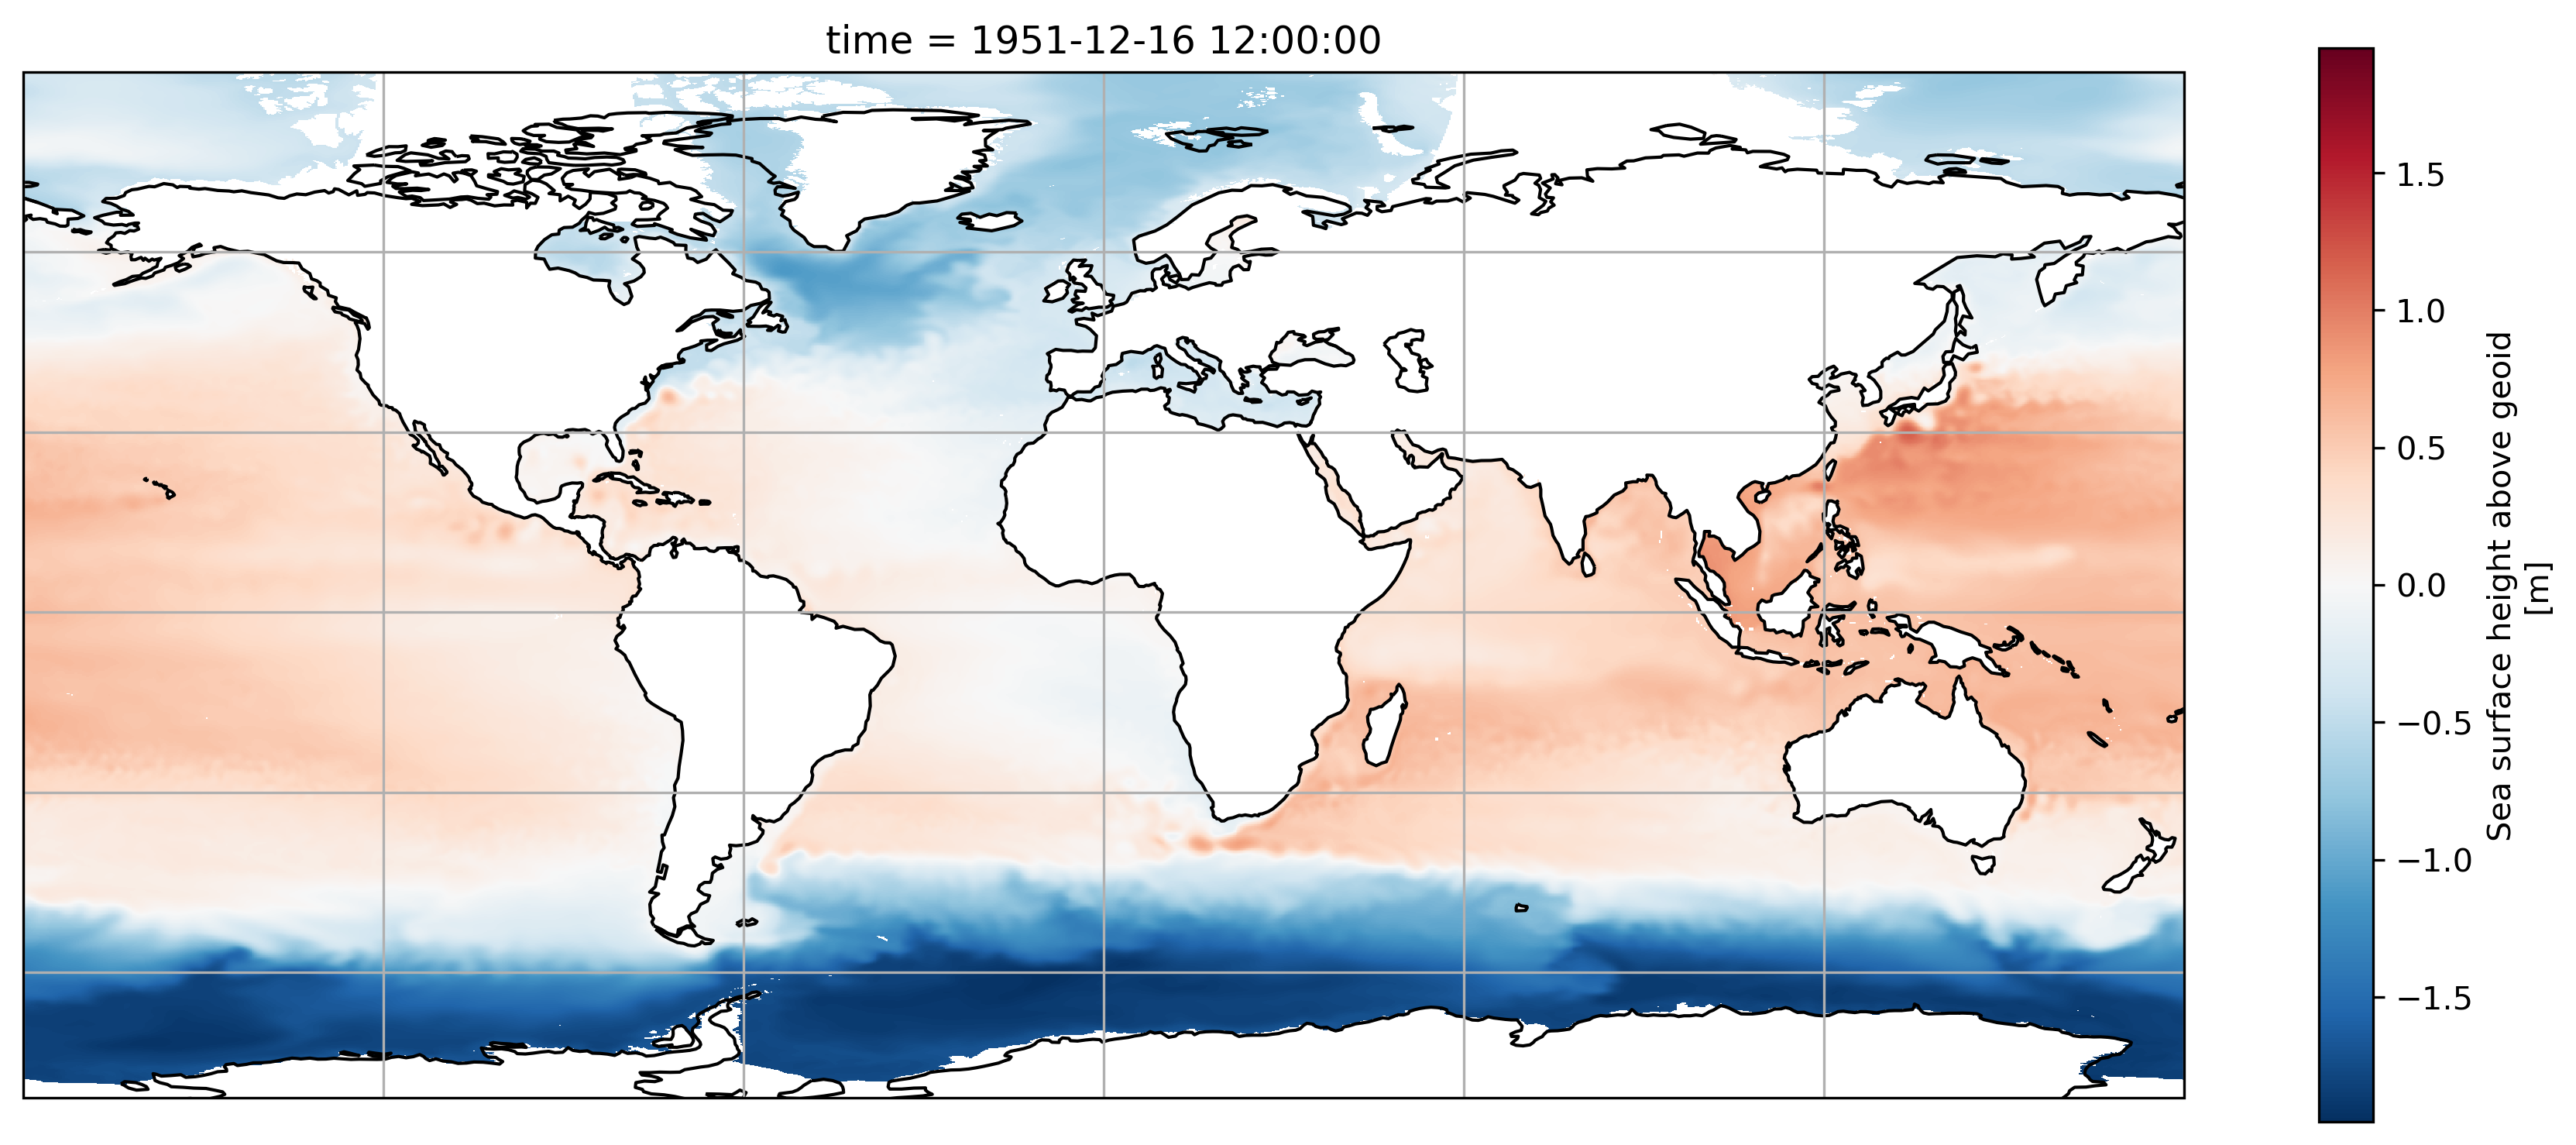

In [8]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax)
ax.coastlines()
_ = ax.gridlines()

#### Fixing the plot axes

Notice that the white land-masked regions are distorted away from the coastlines in the Arctic in the above plot. This is because a tripolar grid is used, so the grid lines are not zonal and meridional north of 65N, and consequently the nominal 1D coordinates `xh` and `yh` are incorrect. To fix this we need to use 2d coordinates `geolon` and `geolat`.

We can get these coorindates from the intake-esm datastore. However, note that `geolon` and `geolat` contain NaNs in regions where processors were masked over land. Below we replace these NaNs with zeros so that the coordinates can be used for plotting.

In [9]:
coords = datastore.search(variable=["geolat", "geolon"]).to_dask().compute()
coords = coords.fillna(0.0)

zos = zos.assign_coords(coords)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.09/lib/python3.11/site-packages/intake_esm/source.py:308: ConcatenationWarning: Attempting to concatenate datasets without valid dimension coordinates: retaining only first dataset. Request valid dimension coordinate to silence this warning.
  warnings.warn(


In [ ]:
proj = ccrs.PlateCarree()
fig, ax = plt.subplots(figsize=(15,6), subplot_kw=dict(projection=proj))

zos["zos"].isel(time=-1).plot(ax=ax, x="geolon", y="geolat")

ax.coastlines()
_ = ax.gridlines()
plt.savefig(plotfolder+'exampleout.png')

In [ ]:
client.close()